# **Load and process data**

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import os
import time
import json

path_to_file = tf.keras.utils.get_file('movies.json', 'https://raw.githubusercontent.com/google-research-datasets/Taskmaster/master/TM-2-2020/data/movies.json')

with open(path_to_file) as file:
  data = json.load(file)

user = list()
assistant = list()
sentence = '<start>'

for conversation in data:
  user_has_not_started = True
  # The conversation starts with the user speaks first
  user_is_talking = True
  assistant_is_talking = False

  for utterance in conversation['utterances']:
    if utterance['speaker'] == 'ASSISTANT' and user_has_not_started:
      continue
    else:
      user_has_not_started = False
    
      # process the utterance  
      buffer = utterance['text']
      if utterance.get('segments'):
        for segment in utterance.get('segments'):
          annotation = segment.get('annotations')[0]['name']
          annotation = '<' + annotation.replace('.','<>').replace('_','<>') + '>'
          buffer = buffer.replace(segment.get('text'), annotation)
      
      if utterance['speaker'] == 'USER':
        if assistant_is_talking:
          # finish assistant's sentence
          sentence = ' '.join(sentence.split(' ')[:-1]) + ' ' + '<end>'
          assistant.append(sentence)
          assistant_is_talking = False

          # reset the sentence for user
          sentence = '<start>'
          user_is_talking = True
      
      if utterance['speaker'] == 'ASSISTANT':
        if user_is_talking:
          # finish user's sentence
          sentence = ' '.join(sentence.split(' ')[:-1]) + ' ' + '<end>'
          user.append(sentence)
          user_is_talking = False

          # reset the sentence for assistant
          sentence = '<start>'
          assistant_is_talking = True
          
      # append to the sentence
      sentence = sentence + ' ' + buffer + ' ' + '<pause>'
  
  if assistant_is_talking:
    sentence = ' '.join(sentence.split(' ')[:-1]) + ' ' + '<end>'
    assistant.append(sentence)
  
print('Lenght User: {}'.format(len(user)))
print('Lenght Assistant: {}'.format(len(assistant)))

21192704/21189893 [==============================] - 0s 0us/step
Lenght User: 23961
Lenght Assistant: 23961


In [4]:
a = list()
for conversation in data:
  for utterance in conversation['utterances']:
    if utterance.get('segments'):
      for segment in utterance.get('segments'):
        a.extend(segment['annotations'])

a = list(map(lambda x: x['name'].replace('.','<>').replace('_','<>'), a))
print(len(set(a)))

26


There are 26 different types of annotation in this dataset.

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token='<OOV>', filters='\'!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(assistant + user)

word_index = tokenizer.word_index

print('Vocabulary length: {}'.format(len(word_index)))

encoder_input = tokenizer.texts_to_sequences(user)
decoder_input = tokenizer.texts_to_sequences(assistant)
target = list()
for inp in decoder_input:
  a = inp[1:]
  a.append(0)
  target.append(a)

encoder_input = pad_sequences(encoder_input, padding='post')
decoder_input = pad_sequences(decoder_input, padding='post')
target = pad_sequences(target, padding='post')

max_encoder_len = len(encoder_input[0])
max_decoder_len = len(decoder_input[0])

print('Sample encoder:')
print(encoder_input[0])
print('Sample decoder:')
print(decoder_input[0])
print('Sample target:')
print(target[0])
print('Max length encoder: {}'.format(max_encoder_len))
print('Max length decoder: {}'.format(max_decoder_len))
print('Dataset size: {}'.format(len(encoder_input)))

dataset = tf.data.Dataset.from_tensor_slices((encoder_input, decoder_input, target))

# Batch size
BATCH_SIZE = 50
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset.take(1))

Vocabulary length: 6580
Sample encoder:
[ 3 21 58 22 62  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Sample decoder:
[  3   5  26  30   4  45  37  10 236  11 148  22   4 231   2   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  

# **LSTM**

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './drive/My Drive/data/checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 171)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 140, 200)     1316200     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 171, 200)     1316200     input_4[0][0]                    
_______________________________________________________________________________________

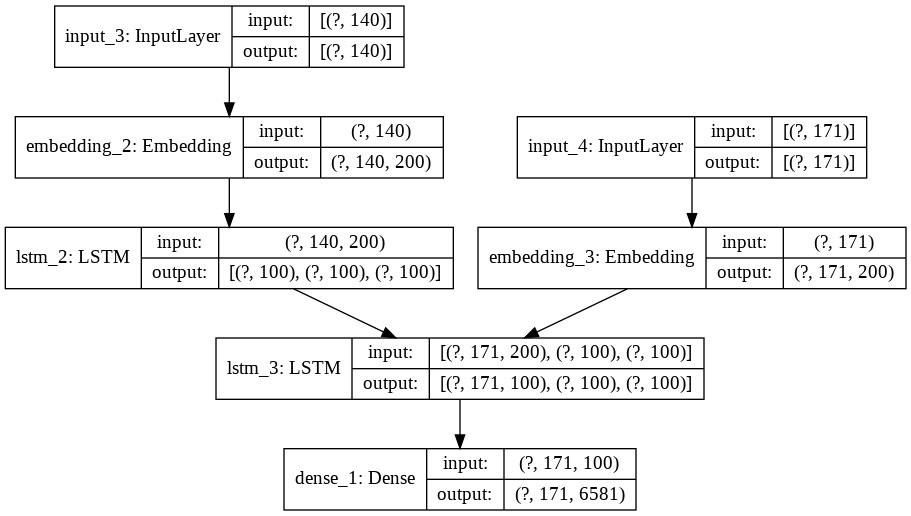

In [ ]:
EMBEDDING_DIM = 200
RNN_UNITS = 100
VOCAB_SIZE = len(word_index) + 1 # word_index count from 1, but keras layers count from 0

def build_train_model(embedding_dim, rnn_units, vocab_size):
  # encoding
  encoder_inputs = tf.keras.layers.Input(shape=(max_encoder_len,))
  encoder_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
  encoder_outputs, state_h, state_c = tf.keras.layers.LSTM(rnn_units, return_state=True)(encoder_embedding)
  encoder_states = [state_h, state_c]

  # decoding
  decoder_inputs = tf.keras.layers.Input(shape=(max_decoder_len,))
  decoder_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
  decoder_outputs , _ , _ = tf.keras.layers.LSTM(rnn_units , return_state=True , return_sequences=True )(decoder_embedding, initial_state=encoder_states)
  output = tf.keras.layers.Dense(vocab_size, activation=tf.keras.activations.softmax)(decoder_outputs)

  return tf.keras.models.Model([encoder_inputs, decoder_inputs], output )

train_model = build_train_model(EMBEDDING_DIM, RNN_UNITS, VOCAB_SIZE)
train_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
train_model.summary()
tf.keras.utils.plot_model(train_model, show_shapes=True)

In [ ]:
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
STARTING_EPOCH = 30
EPOCHS = 100

train_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    run_eagerly=False)

history = train_model.fit([encoder_input , decoder_input], target, initial_epoch=STARTING_EPOCH, epochs=EPOCHS, callbacks=[checkpoint_callback]) 

Epoch 31/100
749/749 [==============================] - 71s 95ms/step - loss: 0.0900
Epoch 32/100
749/749 [==============================] - 71s 95ms/step - loss: 0.0888
Epoch 33/100
749/749 [==============================] - 71s 94ms/step - loss: 0.0875
Epoch 34/100
749/749 [==============================] - 71s 94ms/step - loss: 0.0864
Epoch 35/100
749/749 [==============================] - 70s 94ms/step - loss: 0.0852
Epoch 36/100
749/749 [==============================] - 70s 94ms/step - loss: 0.0841
Epoch 37/100
749/749 [==============================] - 70s 93ms/step - loss: 0.0831
Epoch 38/100
749/749 [==============================] - 70s 93ms/step - loss: 0.0821
Epoch 39/100
749/749 [==============================] - 70s 94ms/step - loss: 0.0811
Epoch 40/100
749/749 [==============================] - 70s 93ms/step - loss: 0.0801
Epoch 41/100
749/749 [==============================] - 70s 93ms/step - loss: 0.0792
Epoch 42/100
749/749 [==============================] - 70s 93ms/

# **Build inference model**

In [ ]:
def build_inference_models(embedding_dim, rnn_units, vocab_size):
  # encoding
  encoder_inputs = tf.keras.layers.Input(shape=(max_encoder_len,), name='en_input')
  encoder_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=False, name='en_embedding')(encoder_inputs)
  encoder_outputs, state_h, state_c = tf.keras.layers.LSTM(rnn_units, return_state=True, name='en_lstm')(encoder_embedding)
  encoder_states = [state_h, state_c]
  
  encoding_model = tf.keras.models.Model(encoder_inputs, encoder_states)

  # decoding
  decoder_state_input_h = tf.keras.layers.Input(dtype='float32', shape=(None,), name='dec_input_h')
  decoder_state_input_c = tf.keras.layers.Input(dtype='float32', shape=(None,), name='dec_input_c')  
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  decoder_inputs = tf.keras.layers.Input(dtype='float32', shape=(max_decoder_len,), name='dec_input')

  decoder_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=False, name='dec_embedding')(decoder_inputs)
  decoder_outputs , decoder_state_h , decoder_state_c = tf.keras.layers.LSTM(rnn_units, return_state=True , return_sequences=True, name='dec_lstm')(decoder_embedding, initial_state=decoder_states_inputs)
  decoder_states_outputs = [decoder_state_h, decoder_state_c]
  output = tf.keras.layers.Dense(vocab_size, activation=tf.keras.activations.softmax, name='dec_dense')(decoder_outputs)
  
  decoding_model = tf.keras.models.Model([decoder_inputs] + decoder_states_inputs, [output] + decoder_states_outputs)

  return encoding_model, decoding_model

In [ ]:
trained_model.layers

In [ ]:
en_model, dec_model = build_inference_models(EMBEDDING_DIM, RNN_UNITS, VOCAB_SIZE)
trained_model = build_train_model(EMBEDDING_DIM, RNN_UNITS, VOCAB_SIZE)
trained_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

en_model.layers[1].set_weights(trained_model.layers[2].get_weights())
en_model.layers[2].set_weights(trained_model.layers[4].get_weights())

dec_model.layers[1].set_weights(trained_model.layers[3].get_weights())
dec_model.layers[4].set_weights(trained_model.layers[5].get_weights())
dec_model.layers[5].set_weights(trained_model.layers[6].get_weights())

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'./drive/My Drive/data/checkpoint/ckpt_100'

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
en_input (InputLayer)        [(None, 140)]             0         
_________________________________________________________________
en_embedding (Embedding)     (None, 140, 200)          1316200   
_________________________________________________________________
en_lstm (LSTM)               [(None, 100), (None, 100) 120400    
Total params: 1,436,600
Trainable params: 1,436,600
Non-trainable params: 0
_________________________________________________________________


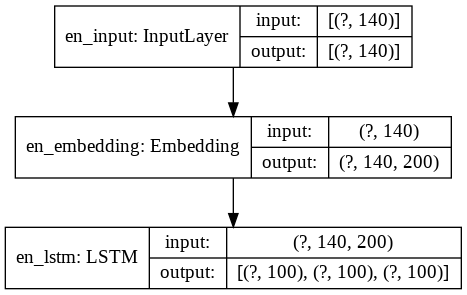

In [ ]:
en_model.summary()
tf.keras.utils.plot_model(en_model, show_shapes=True)

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_input (InputLayer)          [(None, 171)]        0                                            
__________________________________________________________________________________________________
dec_embedding (Embedding)       (None, 171, 200)     1316200     dec_input[0][0]                  
__________________________________________________________________________________________________
dec_input_h (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_input_c (InputLayer)        [(None, None)]       0                                            
______________________________________________________________________________________

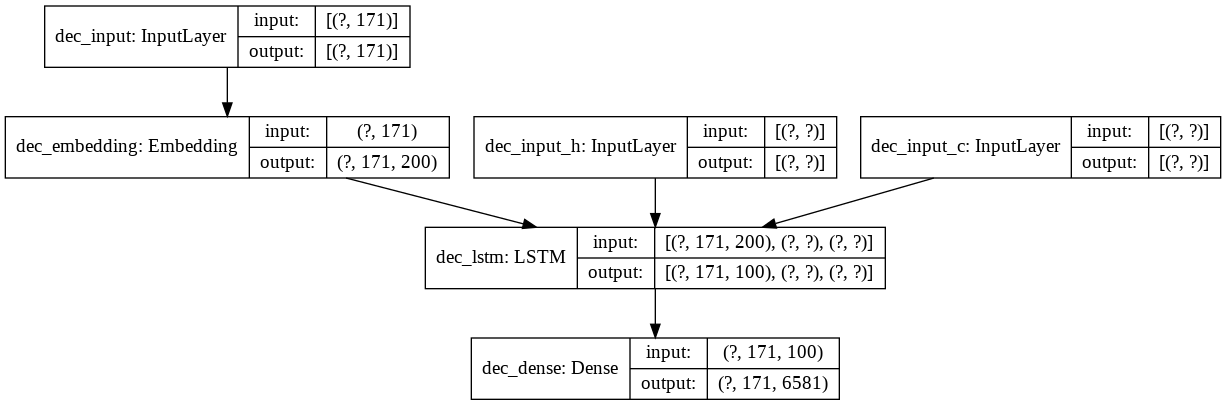

In [ ]:
dec_model.summary()
tf.keras.utils.plot_model(dec_model, show_shapes=True)

# **Evaluate**

In [ ]:
def generate_text(question):

  # Converting our question to numbers (vectorizing)
  en_input = tokenizer.texts_to_sequences([question])
  en_input = pad_sequences(en_input, maxlen=max_encoder_len, padding='post')
  
  states = en_model(en_input)
  
  de_input = np.zeros((1, 1)) # starting with an empty string
  de_input[0, 0] = tokenizer.texts_to_sequences('<start>')[0][0]
  
  response_generated = []
  temperature = 1
  count = 0
  
  while True:
    predictions, state_h, state_c = dec_model([de_input] + states)
    predictions = tf.squeeze(predictions, [1])

    # using a categorical distribution to predict the character returned by the model
    predictions = predictions / temperature
    #print(predictions)
    predicted_id = np.argmax(predictions[0])
    #print(predicted_id)

    if tokenizer.sequences_to_texts([[predicted_id]])[0] != '<eov>':
      count +=1
      de_input = tf.expand_dims([predicted_id], 0)
      #print(tokenizer.sequences_to_texts([[predicted_id]]))
      response_generated.append(tokenizer.sequences_to_texts([[predicted_id]])[0])
      
      if count == 10:
        break  
    else:
      response_generated.append('\n')
      break
  
  return (' '.join(response_generated))

In [ ]:
question = input('Customer says:')
response = generate_text(question)
print('Assistant says: {}'.format(response))

Customer says:what
Assistant says: kid upon embarks cold d dreams finds rest buying little
